## Exploratory Data Analysis

Our goal is to understand temperature patterns at RDU Airport to inform feature engineering decisions.

Key questions:
1. Is there a trend component?
2. What seasonality patterns exist (daily, weekly, annual)?
3. What are the autocorrelation patterns?
4. Are there anomalies in the data?

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

CONFIG = {
    'data_start': '2018-01-01 00:00',
    'train_end': '2025-08-31 23:00',
    'val_start': '2025-09-01 00:00',
    'val_end': '2025-09-16 23:00',
    'test_start': '2025-09-17 00:00',
    'test_end': '2025-09-30 23:00',
    'timezone': 'America/New_York',
}

# Load data
df = pd.read_csv("rdu_weather_full.csv", index_col=0, parse_dates=True)

# Convert to Eastern Time
dt_index = pd.to_datetime(df.index, utc=True, errors='raise')
df.index = dt_index.tz_convert(CONFIG['timezone'])

print("Dataset Overview")
print("="*60)
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total hours: {len(df):,}")
print(f"Missing values: {df['temp'].isna().sum()} ({df['temp'].isna().sum()/len(df)*100:.2f}%)")
print(f"\nTemperature statistics:")
print(df['temp'].describe())

Dataset Overview
Date range: 2018-01-01 00:00:00-05:00 to 2025-09-30 23:00:00-04:00
Total hours: 67,919
Missing values: 0 (0.00%)

Temperature statistics:
count    67919.000000
mean        17.045498
std          9.192286
min        -15.600000
25%         10.000000
50%         18.300000
75%         23.900000
max         40.000000
Name: temp, dtype: float64


### 1. Anomaly Detection

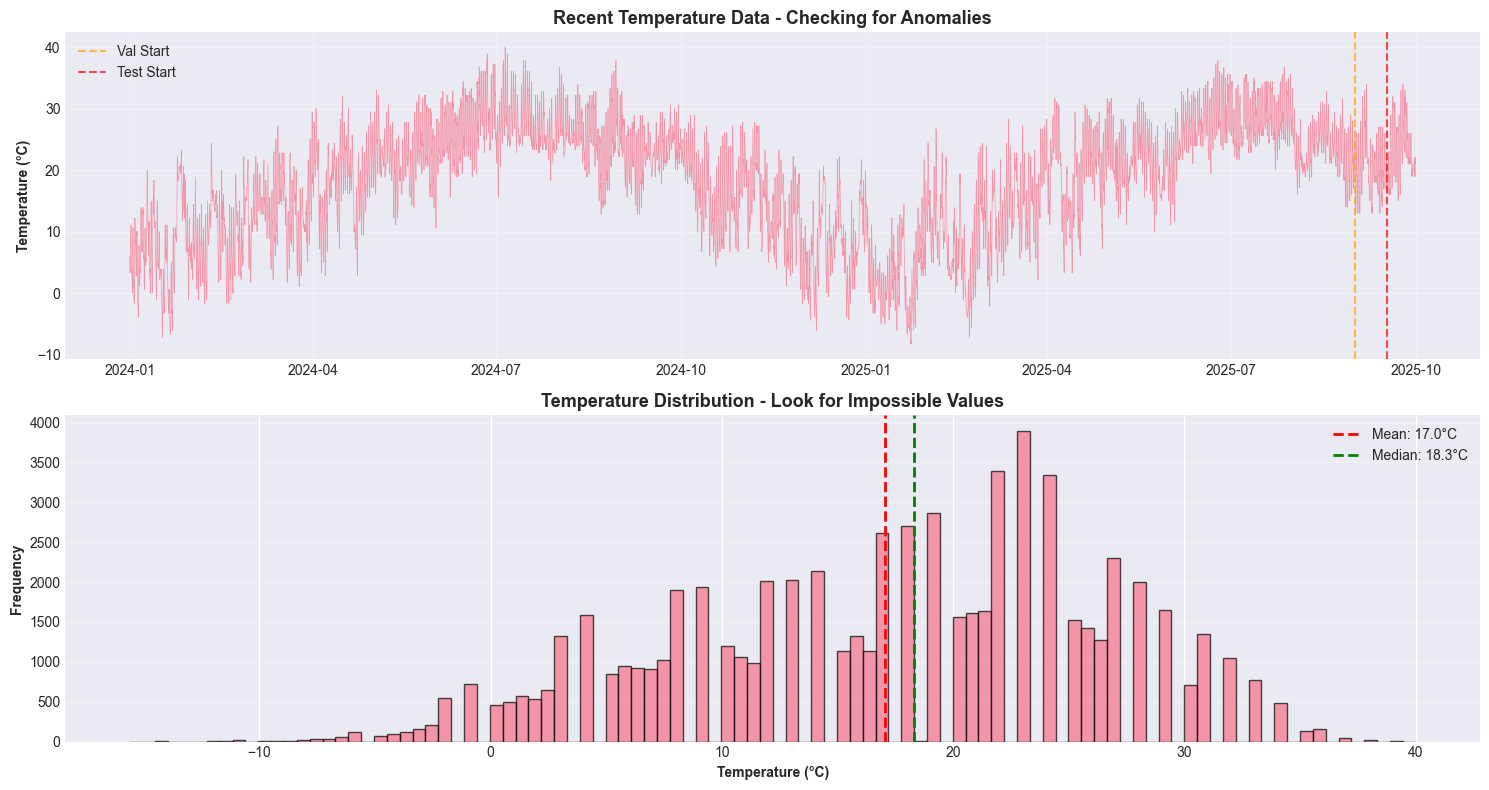


Statistical outliers (±3σ): 31
Physically impossible values: 0
Sudden jumps (>15°C/hour): 0


In [31]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Recent temperature time series (easier to spot anomalies)
ax = axes[0]
recent = df['2024-01-01':CONFIG['test_end']]
ax.plot(recent.index, recent['temp'], linewidth=0.5, alpha=0.7)
ax.axvline(pd.Timestamp(CONFIG['val_start']), color='orange', linestyle='--', alpha=0.7, label='Val Start')
ax.axvline(pd.Timestamp(CONFIG['test_start']), color='red', linestyle='--', alpha=0.7, label='Test Start')
ax.set_ylabel('Temperature (°C)', fontweight='bold')
ax.set_title('Recent Temperature Data - Checking for Anomalies', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Histogram to spot outliers
ax = axes[1]
ax.hist(df['temp'].dropna(), bins=100, edgecolor='black', alpha=0.7)
ax.axvline(df['temp'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["temp"].mean():.1f}°C')
ax.axvline(df['temp'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["temp"].median():.1f}°C')
ax.set_xlabel('Temperature (°C)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Temperature Distribution - Look for Impossible Values', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical outlier detection (±3σ method)
mean_temp = df['temp'].mean()
std_temp = df['temp'].std()
anomalies_3sigma = (df['temp'] < mean_temp - 3*std_temp) | (df['temp'] > mean_temp + 3*std_temp)

print(f"\nStatistical outliers (±3σ): {anomalies_3sigma.sum()}")

# Detect physically impossible values for RDU
# Historical RDU: Record low = -16°C (1985), Record high = 41°C (2012)
anomalies_physical = (df['temp'] < -20) | (df['temp'] > 45)
print(f"Physically impossible values: {anomalies_physical.sum()}")

if anomalies_physical.sum() > 0:
    print("\nAnomalous values found:")
    print(df[anomalies_physical][['temp']].sort_values('temp').head(20))
    
# Detect sudden jumps (>15°C change in 1 hour)
temp_diff = df['temp'].diff().abs()
sudden_jumps = temp_diff > 15
print(f"Sudden jumps (>15°C/hour): {sudden_jumps.sum()}")

if sudden_jumps.sum() > 0:
    print("\nSudden temperature jumps:")
    print(df[sudden_jumps][['temp']])

## 2. Time Series Decomposition
Break the time series down into trend and seasonality components"

Running seasonal decomposition (period=168h for weekly)...


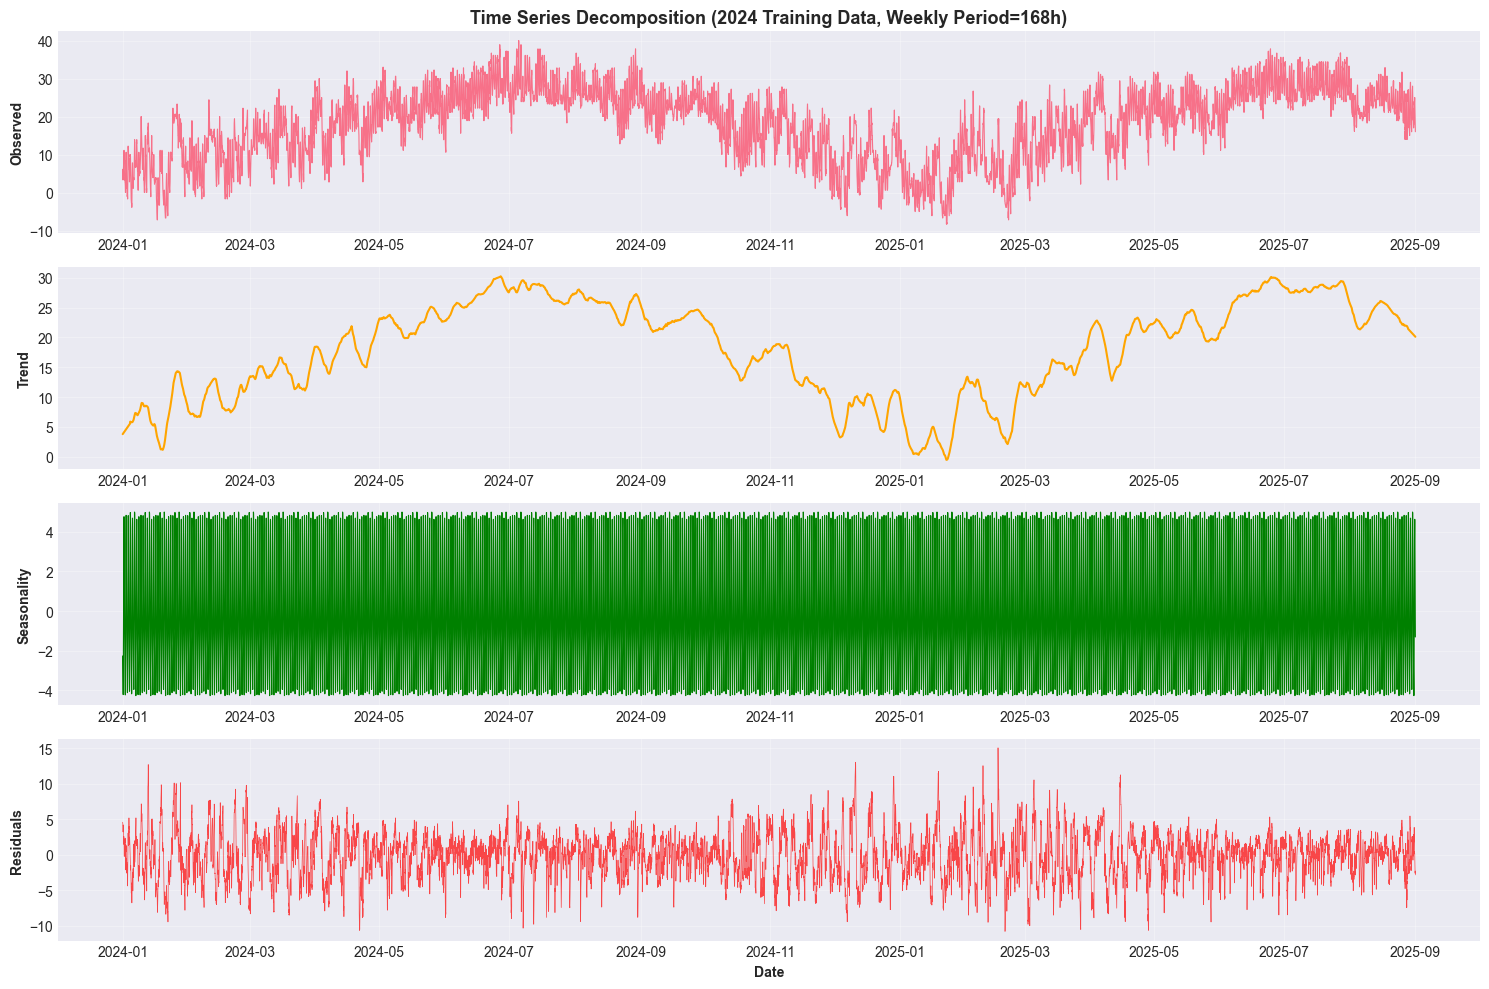


Decomposition Analysis:
  Seasonal range: 9.26°C
  Residual std: 3.25°C
  Ratio (seasonal/residual): 2.85
  Seasonality strength: STRONG


In [32]:
# Use 2024 training data for cleaner visualization
train_2024 = df[(df.index >= '2024-01-01') & (df.index <= CONFIG['train_end'])]['temp'].dropna()

# Decompose with weekly seasonality (168 hours = 7 days)
print("Running seasonal decomposition (period=168h for weekly)...")
decomposition = seasonal_decompose(train_2024, model='additive', period=168, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

axes[0].plot(decomposition.observed, linewidth=0.8)
axes[0].set_ylabel('Observed', fontweight='bold')
axes[0].set_title('Time Series Decomposition (2024 Training Data, Weekly Period=168h)', fontweight='bold', fontsize=13)
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, linewidth=1.5, color='orange')
axes[1].set_ylabel('Trend', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, linewidth=0.8, color='green')
axes[2].set_ylabel('Seasonality', fontweight='bold')
axes[2].grid(True, alpha=0.3)
# CRITICAL: Check this y-axis range vs residuals below!

axes[3].plot(decomposition.resid, linewidth=0.5, color='red', alpha=0.7)
axes[3].set_ylabel('Residuals', fontweight='bold')
axes[3].set_xlabel('Date', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare magnitudes
seasonal_range = decomposition.seasonal.max() - decomposition.seasonal.min()
residual_std = decomposition.resid.std()

print("\nDecomposition Analysis:")
print(f"  Seasonal range: {seasonal_range:.2f}°C")
print(f"  Residual std: {residual_std:.2f}°C")
print(f"  Ratio (seasonal/residual): {seasonal_range/residual_std:.2f}")
print(f"  Seasonality strength: {'STRONG' if seasonal_range > 2*residual_std else 'WEAK'}")

## 3. Autocorrelation Analysis

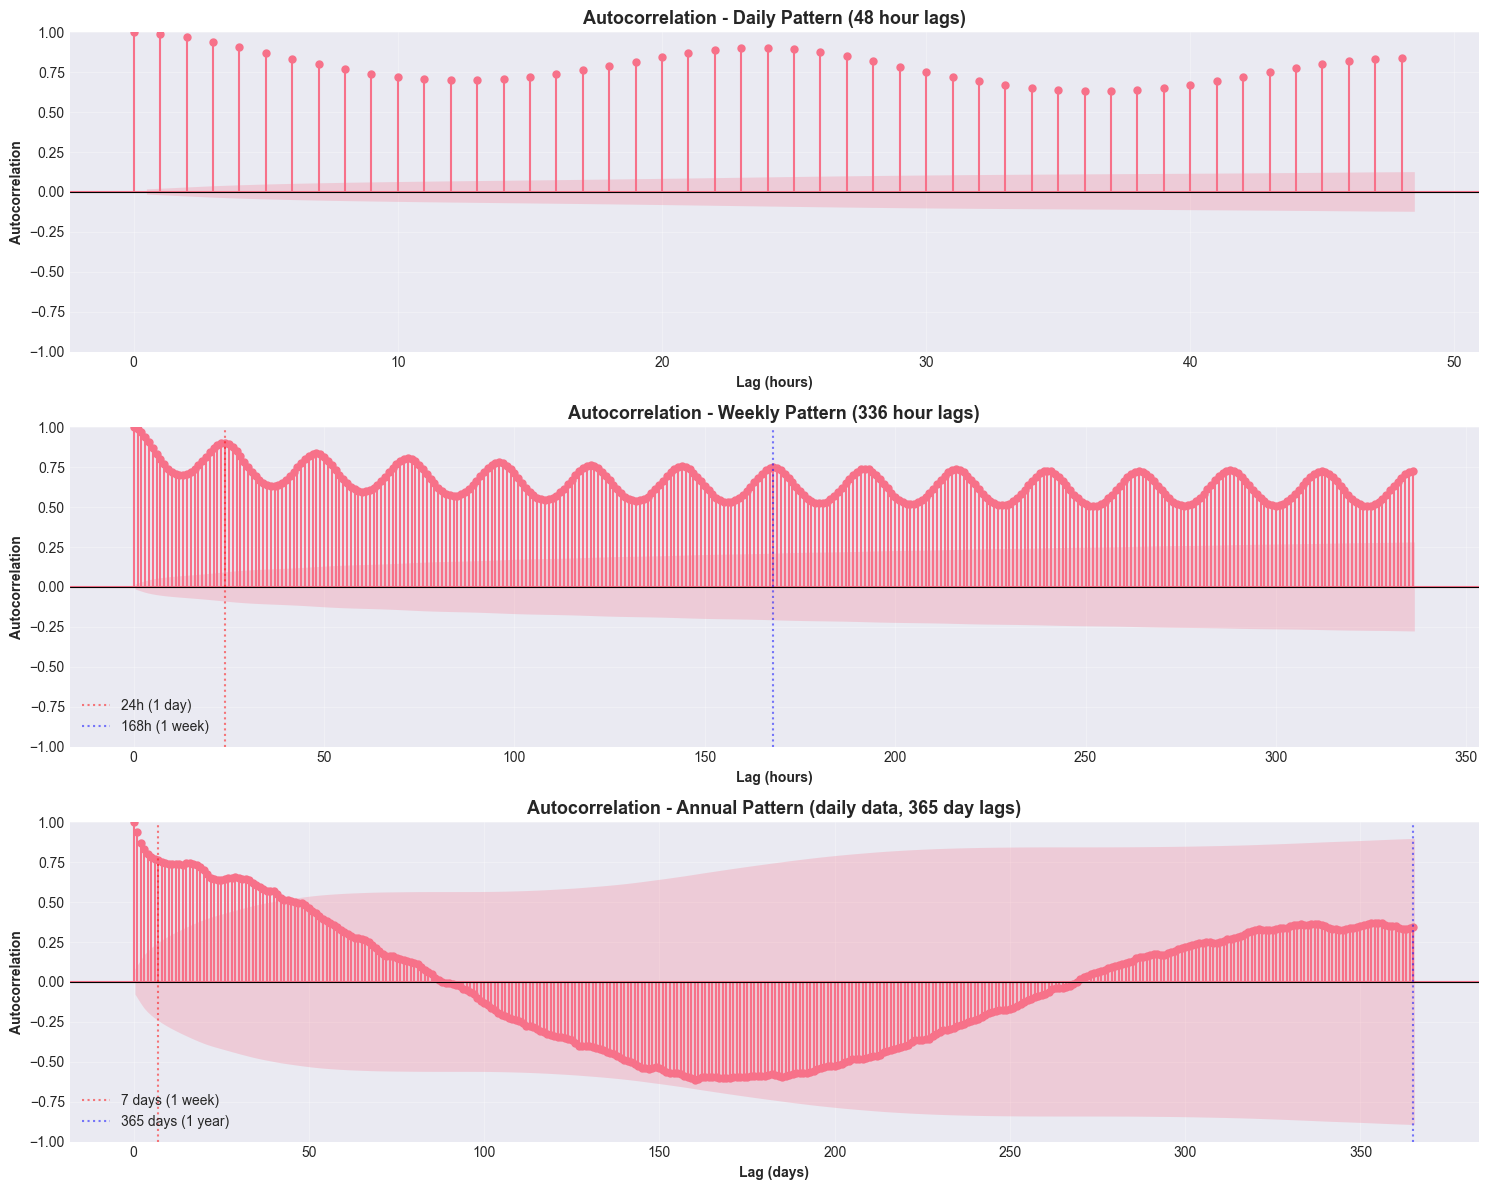


Key Autocorrelation Findings:
  Blue shaded region = statistically insignificant (noise)
  Outside blue region = real autocorrelation signal

  Expected strong lags:
    - 24h (yesterday same hour)
    - 168h (last week same hour)
    - 8760h (last year same time) - if using enough historical data


In [33]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Daily pattern (48 hours to see 2 full days)
ax = axes[0]
plot_acf(train_2024, lags=48, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation - Daily Pattern (48 hour lags)', fontweight='bold', fontsize=13)
ax.set_xlabel('Lag (hours)', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3)
ax.set_ylabel('Autocorrelation', fontweight='bold')

# Weekly pattern (336 hours = 2 weeks)
ax = axes[1]
plot_acf(train_2024, lags=336, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation - Weekly Pattern (336 hour lags)', fontweight='bold', fontsize=13)
ax.set_xlabel('Lag (hours)', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=24, color='red', linestyle=':', alpha=0.5, label='24h (1 day)')
ax.axvline(x=168, color='blue', linestyle=':', alpha=0.5, label='168h (1 week)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylabel('Autocorrelation', fontweight='bold')

# Long-range annual pattern (8760 hours = 1 year, but sample every 24h for visibility)
ax = axes[2]
# Downsample to daily for annual view
daily_temps = train_2024.resample('D').mean()
plot_acf(daily_temps, lags=365, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation - Annual Pattern (daily data, 365 day lags)', fontweight='bold', fontsize=13)
ax.set_xlabel('Lag (days)', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=7, color='red', linestyle=':', alpha=0.5, label='7 days (1 week)')
ax.axvline(x=365, color='blue', linestyle=':', alpha=0.5, label='365 days (1 year)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylabel('Autocorrelation', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Autocorrelation Findings:")
print("  Blue shaded region = statistically insignificant (noise)")
print("  Outside blue region = real autocorrelation signal")
print("\n  Expected strong lags:")
print("    - 24h (yesterday same hour)")
print("    - 168h (last week same hour)")
print("    - 8760h (last year same time) - if using enough historical data")

## 4. Daily Seasonality Pattern

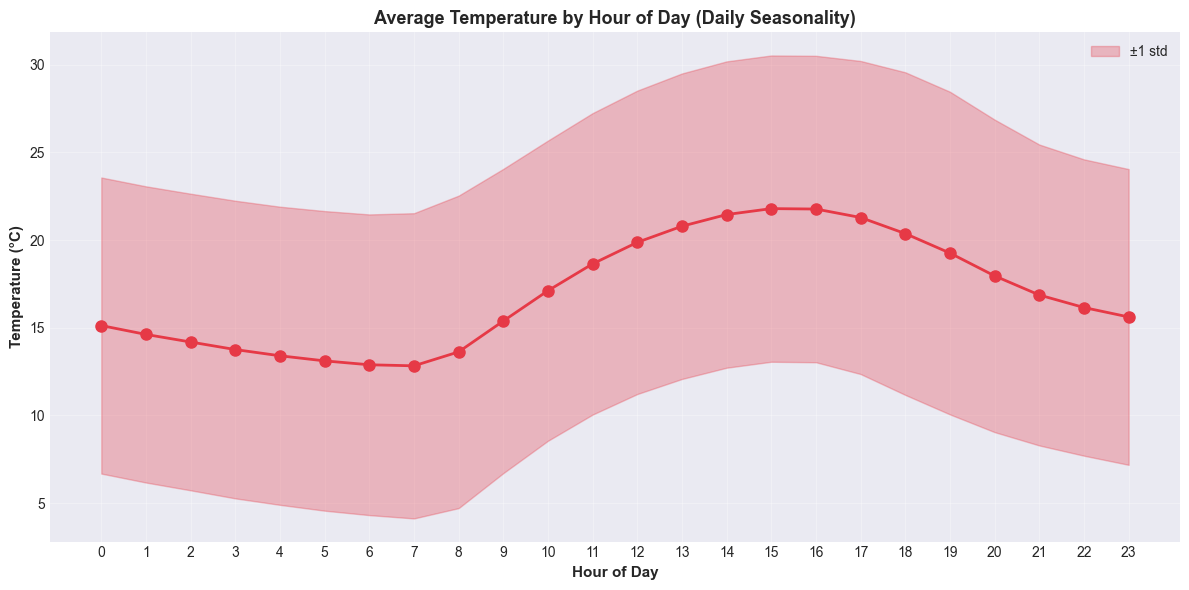


Daily Seasonality Analysis:
  Temperature range across hours: 8.96°C
  Coolest hour: 7:00 (12.8°C)
  Warmest hour: 15:00 (21.8°C)
  Daily seasonality: STRONG (use hour one-hot)


In [34]:
# Average temperature by hour of day (using training data only)
train_data = df[df.index <= CONFIG['train_end']]
hourly_pattern = train_data.groupby(train_data.index.hour)['temp'].agg(['mean', 'std', 'count'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(hourly_pattern.index, hourly_pattern['mean'], marker='o', linewidth=2, markersize=8, color='#E63946')
ax.fill_between(hourly_pattern.index, 
                hourly_pattern['mean'] - hourly_pattern['std'],
                hourly_pattern['mean'] + hourly_pattern['std'],
                alpha=0.3, label='±1 std', color='#E63946')
ax.set_xlabel('Hour of Day', fontweight='bold', fontsize=11)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax.set_title('Average Temperature by Hour of Day (Daily Seasonality)', fontweight='bold', fontsize=13)
ax.set_xticks(range(24))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

daily_range = hourly_pattern['mean'].max() - hourly_pattern['mean'].min()
print(f"\nDaily Seasonality Analysis:")
print(f"  Temperature range across hours: {daily_range:.2f}°C")
print(f"  Coolest hour: {hourly_pattern['mean'].idxmin()}:00 ({hourly_pattern['mean'].min():.1f}°C)")
print(f"  Warmest hour: {hourly_pattern['mean'].idxmax()}:00 ({hourly_pattern['mean'].max():.1f}°C)")
print(f"  Daily seasonality: {'STRONG (use hour one-hot)' if daily_range > 5 else 'MODERATE'}")

## 5. Weekly Seasonality Pattern
Check if weekday vs weekend matters

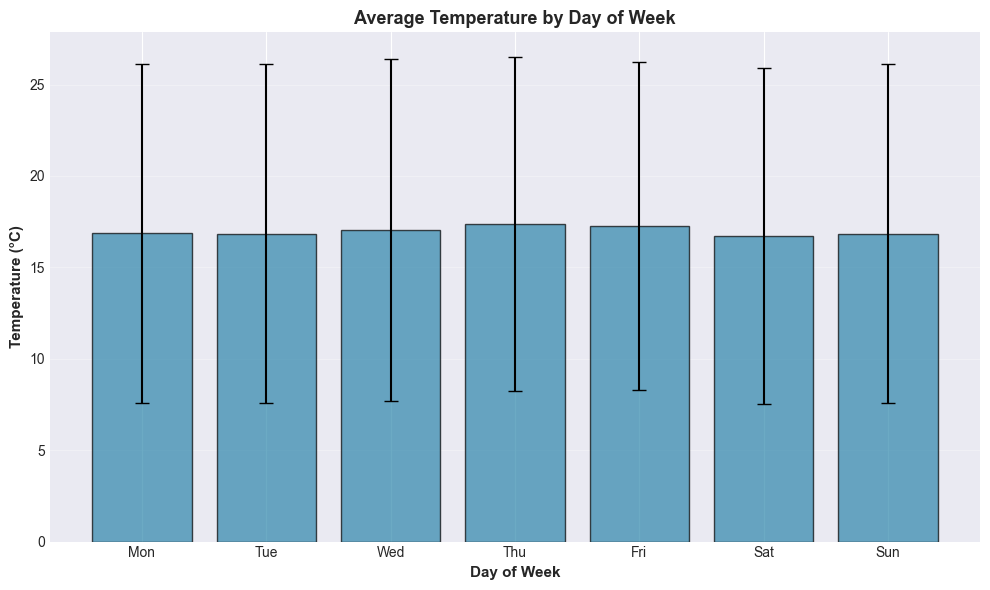


Weekly Seasonality Analysis:
  Temperature range across days: 0.65°C
  Weekly std dev: 0.25°C
  Weekly seasonality: WEAK (may not need day-of-week)


In [35]:
# Average temperature by day of week
weekly_pattern = train_data.groupby(train_data.index.dayofweek)['temp'].agg(['mean', 'std', 'count'])
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(7), weekly_pattern['mean'], yerr=weekly_pattern['std'], 
       capsize=5, alpha=0.7, edgecolor='black', color='#2E86AB')
ax.set_xlabel('Day of Week', fontweight='bold', fontsize=11)
ax.set_ylabel('Temperature (°C)', fontweight='bold', fontsize=11)
ax.set_title('Average Temperature by Day of Week', fontweight='bold', fontsize=13)
ax.set_xticks(range(7))
ax.set_xticklabels(day_names)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

weekly_range = weekly_pattern['mean'].max() - weekly_pattern['mean'].min()
print(f"\nWeekly Seasonality Analysis:")
print(f"  Temperature range across days: {weekly_range:.2f}°C")
print(f"  Weekly std dev: {weekly_pattern['mean'].std():.2f}°C")
print(f"  Weekly seasonality: {'WEAK (may not need day-of-week)' if weekly_range < 2 else 'MODERATE/STRONG'}")

## 6. Annual Seasonality
Check long-term trends and seasonal patterns

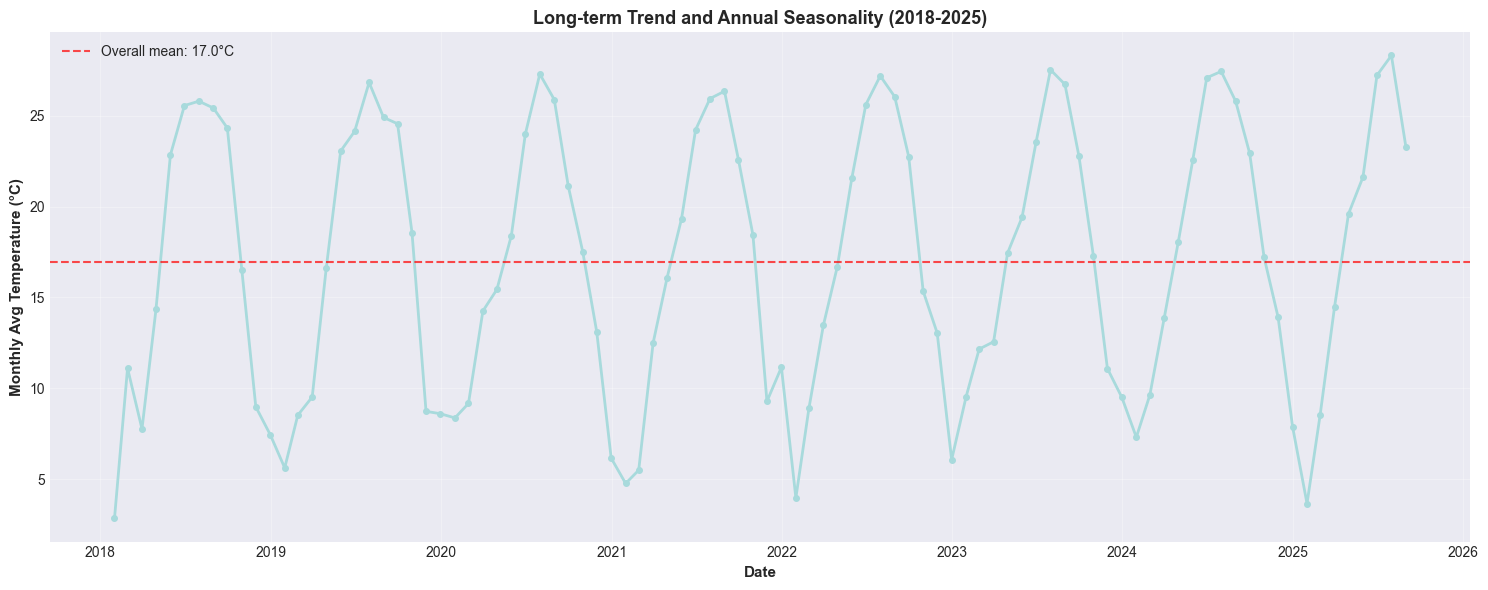


Annual Pattern:
  Overall temperature trend: INCREASING
  Clear seasonal cycle: YES (summer warm, winter cold)


In [36]:
# Monthly averages
monthly = train_data['temp'].resample('M').mean()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=4, color='#A8DADC')
ax.axhline(monthly.mean(), color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Overall mean: {monthly.mean():.1f}°C')
ax.set_xlabel('Date', fontweight='bold', fontsize=11)
ax.set_ylabel('Monthly Avg Temperature (°C)', fontweight='bold', fontsize=11)
ax.set_title('Long-term Trend and Annual Seasonality (2018-2025)', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAnnual Pattern:")
print(f"  Overall temperature trend: {'INCREASING' if monthly.iloc[-12:].mean() > monthly.iloc[:12].mean() else 'STABLE/DECREASING'}")
print(f"  Clear seasonal cycle: YES (summer warm, winter cold)")

## 7. Recent Data Check (What model will see)
Visualize the last few months leading up to test period

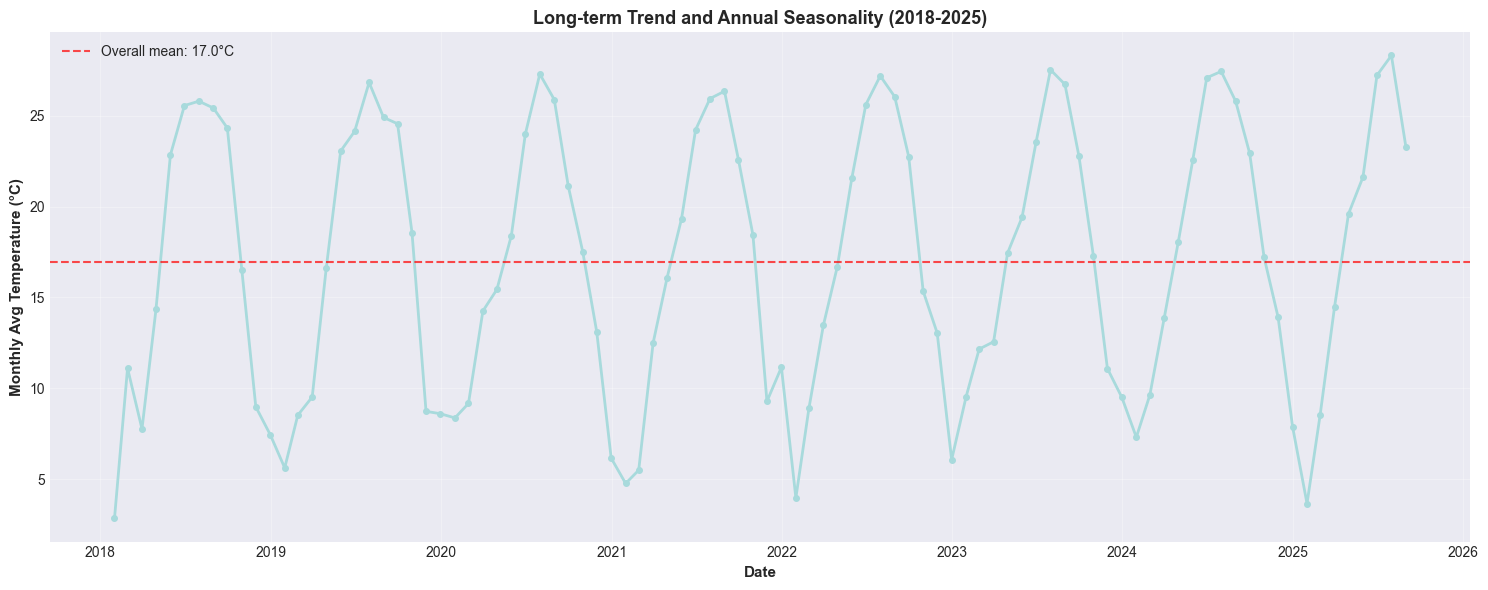


Annual Pattern:
  Overall temperature trend: INCREASING
  Clear seasonal cycle: YES (summer warm, winter cold)


In [37]:
# Monthly averages
monthly = train_data['temp'].resample('M').mean()

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=4, color='#A8DADC')
ax.axhline(monthly.mean(), color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Overall mean: {monthly.mean():.1f}°C')
ax.set_xlabel('Date', fontweight='bold', fontsize=11)
ax.set_ylabel('Monthly Avg Temperature (°C)', fontweight='bold', fontsize=11)
ax.set_title('Long-term Trend and Annual Seasonality (2018-2025)', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAnnual Pattern:")
print(f"  Overall temperature trend: {'INCREASING' if monthly.iloc[-12:].mean() > monthly.iloc[:12].mean() else 'STABLE/DECREASING'}")
print(f"  Clear seasonal cycle: YES (summer warm, winter cold)")

## 8. Feature Correlation Check
Check if our planned lag features (24h, 48h, 168h) make sense

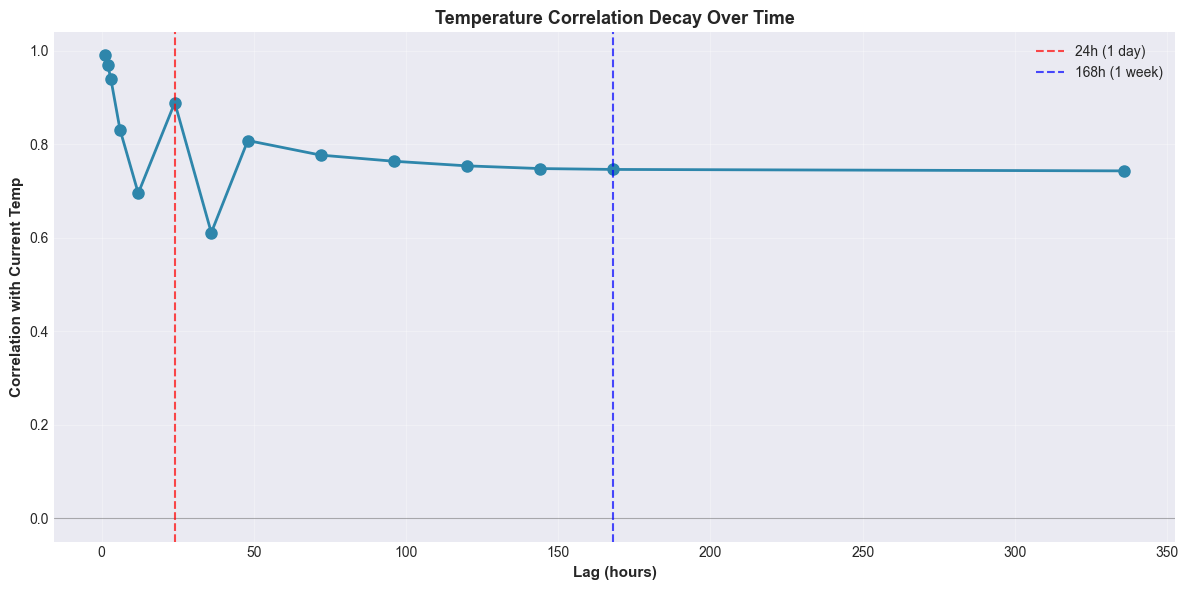

Top correlations by lag:
    1h: 0.990
    2h: 0.969
    3h: 0.939
   24h: 0.889
    6h: 0.831
   48h: 0.808
   72h: 0.777
   96h: 0.763
  120h: 0.754
  144h: 0.748

Our chosen lags performance:
  24h:  0.889 (rank 4)
  48h:  0.808 (rank 6)
  168h: 0.746 (rank 11)


In [41]:
# Analyze multiple lags to see if we missed anything important
temp_df = train_data[['temp']].copy()

# Check a wider range of lags
lags_to_check = [1, 2, 3, 6, 12, 24, 36, 48, 72, 96, 120, 144, 168, 336]
lag_correlations = {}

for lag in lags_to_check:
    temp_df[f'temp_lag_{lag}h'] = temp_df['temp'].shift(lag)
    temp_df_clean = temp_df.dropna()
    correlation = temp_df_clean['temp'].corr(temp_df_clean[f'temp_lag_{lag}h'])
    lag_correlations[lag] = correlation
    temp_df = temp_df.drop(columns=[f'temp_lag_{lag}h'])  # Clean up for next iteration

# Plot the correlation decay
fig, ax = plt.subplots(figsize=(12, 6))
lags = list(lag_correlations.keys())
correlations = list(lag_correlations.values())

ax.plot(lags, correlations, 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax.axvline(x=24, color='red', linestyle='--', alpha=0.7, label='24h (1 day)')
ax.axvline(x=168, color='blue', linestyle='--', alpha=0.7, label='168h (1 week)')
ax.set_xlabel('Lag (hours)', fontweight='bold', fontsize=11)
ax.set_ylabel('Correlation with Current Temp', fontweight='bold', fontsize=11)
ax.set_title('Temperature Correlation Decay Over Time', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Top correlations by lag:")
for lag, corr in sorted(lag_correlations.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {lag:3d}h: {corr:.3f}")

print(f"\nOur chosen lags performance:")
print(f"  24h:  {lag_correlations[24]:.3f} (rank {sorted(lag_correlations.values(), reverse=True).index(lag_correlations[24]) + 1})")
print(f"  48h:  {lag_correlations[48]:.3f} (rank {sorted(lag_correlations.values(), reverse=True).index(lag_correlations[48]) + 1})") 
print(f"  168h: {lag_correlations[168]:.3f} (rank {sorted(lag_correlations.values(), reverse=True).index(lag_correlations[168]) + 1})")

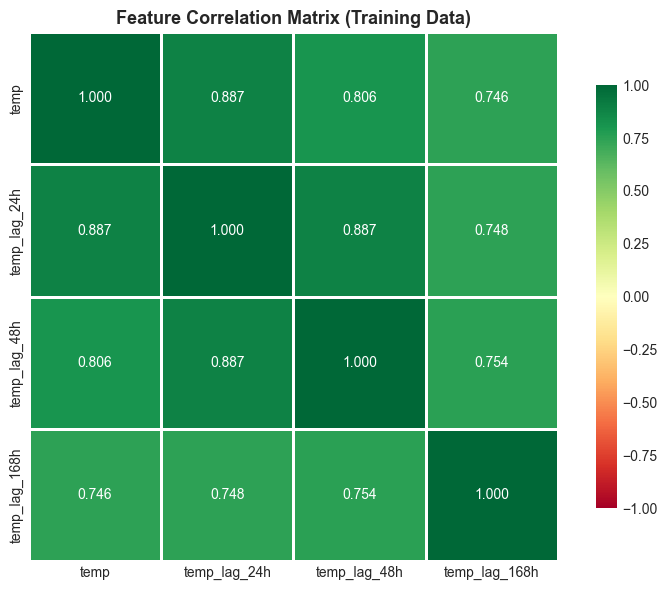


Correlation with target (temp):
temp             1.000000
temp_lag_24h     0.887177
temp_lag_48h     0.805638
temp_lag_168h    0.745952
Name: temp, dtype: float64


In [40]:
# Create temporary features on training data to check correlations
temp_df = train_data[['temp']].copy()
temp_df
temp_df['temp_lag_24h'] = temp_df['temp'].shift(24)
temp_df['temp_lag_48h'] = temp_df['temp'].shift(48)
temp_df['temp_lag_168h'] = temp_df['temp'].shift(168)
temp_df = temp_df.dropna()

# Correlation matrix
corr_matrix = temp_df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix (Training Data)', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

print("\nCorrelation with target (temp):")
print(corr_matrix['temp'].sort_values(ascending=False))